# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "ahmed"
ln1 = "bejaoui"
fn2 = "aymen"
ln2 = "mejri"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_bejaoui_ahmed_and_mejri_aymen.ipynb


In [439]:
!pip install numba

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [0]:
%matplotlib inline

In [0]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit

In [0]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [0]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [0]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [0]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [0]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [0]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

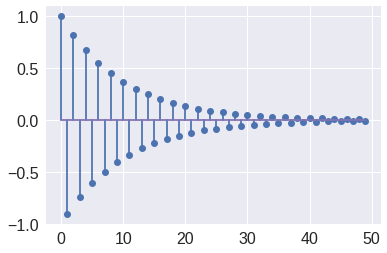

In [448]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [449]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

1.6640073054912245e-06

In [450]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.5321366307552607e-07

### Choice of the model

In [0]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.7)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [452]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.17868281956378038


### Get a very precise minimum to compute distances to minimum

In [453]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5287894317065336
3.5158314663815555e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [0]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [0]:
# Number of iterations
n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [0]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        
        ### TODO
        x=x-step*grad(x, *args)
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [0]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [0]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_tmp=y-step*grad(y, *args)
        t_tmp=(1+np.sqrt(1+4*t**2))/2.
        y_tmp=x_tmp+(t-1)/t_tmp*(x_tmp-x)
        
        x=x_tmp
        y=y_tmp
        t=t_tmp

        ### END TODO
    return x, x_list

In [0]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s nonlinear conjuguate gradient solver. First, define a function to run scipy algorithms and return the list of iterates.

In [0]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [0]:
def f(*args, **kwargs):
    return args[0] + args[1] + kwargs['foo']

In [0]:
f(1, 2, 3, foo=5)
loss=loss_linreg
from scipy.optimize import fmin_cg
from scipy.optimize import fmin_l_bfgs_b



In [463]:
# Nonlinear Conjugate gradient algorithm
from scipy.optimize import fmin_cg

x_init = np.zeros(d)

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

         Current function value: 0.528789
         Iterations: 50
         Function evaluations: 83
         Gradient evaluations: 83


### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [0]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [0]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

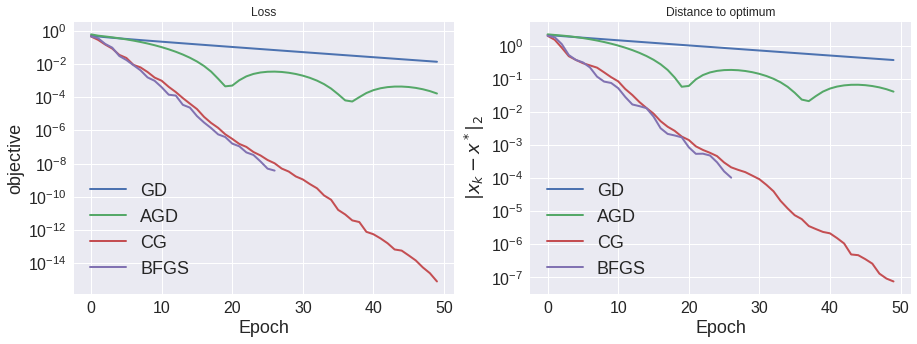

In [466]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs]

solvers = ["GD", "AGD", "CG", "BFGS"]

plot_epochs(monitors, solvers)

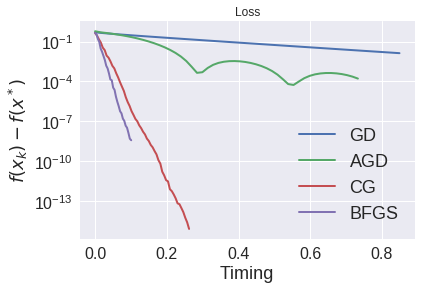

In [467]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

*Interpretation:*

-  Give some first conclusions about the batch solver studied here

<br>
We can notice than the scipy.optimize's CG and BFGS algoritm converge more rapidly than GD and the Accelrated GD. Besides, we also observe that the CG need only few iteration to converge to the True minimum compared BFGS
</br>

- What do you observe about AGD? is it suprising ?

<br>
    The AGD Algorithm has a faster overall convergence than GD. However, we notice than the loss and the distance to the optimum are not monotonically decreasing. In fact ,we can observe some oscillations when using AGD. 
This can be explained by the fact that  AGD is not a gradient descent algorithm ; There is no certainty that for the point $x$ and $ y-\nabla{f(y)}$ computed, we have $f (x)$> $f (y-\nabla{f(y)})$.As we saw on the LAB1, these oscillations are more important and visible when the correlation is large.
</br>
 3asba l mejri

<a id='stoc'></a> 
## 4. Stochastic methods

In [0]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [0]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        x = x - step / np.sqrt(idx + 1) * grad_i(i, x,*args)
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [0]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [0]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    tmp=np.zeros(d)

    for idx in range(n_iter):
        i = iis[idx]        
        tmp=gradient_memory[i,:]
        averaged_gradient-=gradient_memory[i,:]/n
        gradient_memory[i,:]=grad_i(i, x,*args)
        averaged_gradient+=gradient_memory[i,:]/n
        x=x-step*averaged_gradient

        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [0]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [0]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=1, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    grad_old=np.zeros(x.shape[0])
    for idx in range(n_iter):
          
        grad_old = grad( x_old, *args)
        for t in range(n):
            i = iis[t]
            x = x - step * (grad_i(i, x, *args) - grad_i(i, x_old, *args) + grad_old)
        
        x_old=x
        
        ### TODO

        ### END TODO        
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [0]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter, step, args=(A, b, lbda))

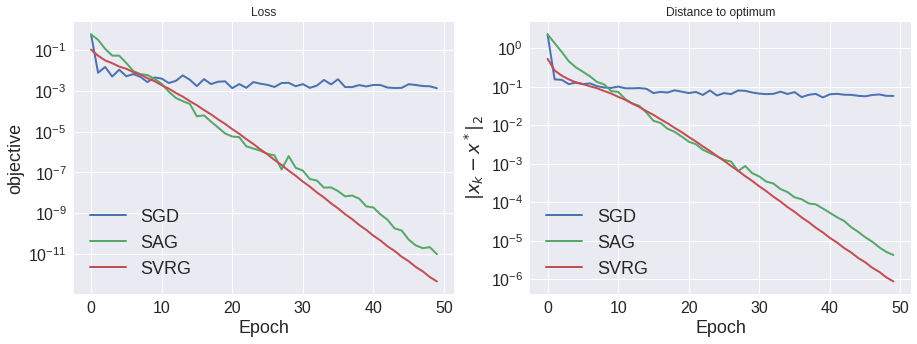

In [477]:
monitors = [monitor_sgd, monitor_sag,monitor_svrg]

solvers = ["SGD", "SAG","SVRG"]

plot_epochs(monitors, solvers)

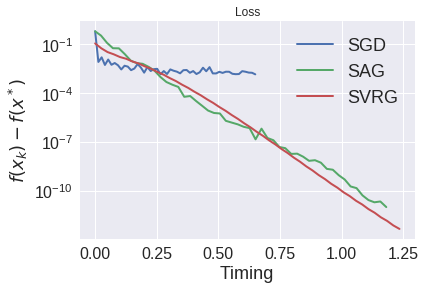

In [478]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

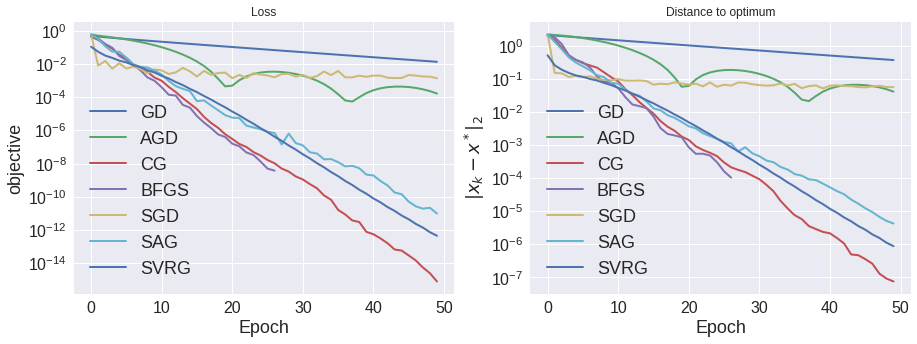

In [479]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

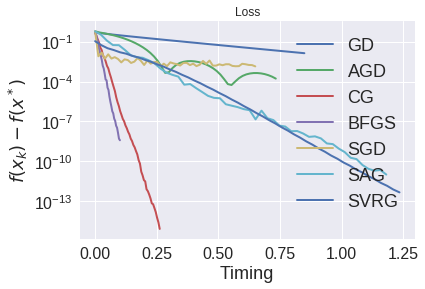

In [480]:
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

## Compare and comment your results
* **SGD :**  The algorithm performs well in the begining and after that it becomes really slow and and does not converge to the minimum. He has a flat convergence after a few iterations. We can also see that the algorithm is suffering from high variance as the distance to the minimum keeps fluctuating.

* **SAG :** This algorithm is really faster than the previous one , but  it remains slower than SVRG. If we raise the iteration number we can see that SAG will reach the true minimum. We notice also that this algrithm is yet suffering from the variance problem.

* **SVRG :** This algorithm is the fastest one between stochastic algoritm. It tends to solves the problem of high variance. In fact, we can see that the gradient's estimation is more stable by visualizing  the graph above ( they are no longer fluctuation with the SVRG methods ).



* For the logistic regression, we can observe that with high correlation ( corr=0.8 in the figure below ) the SVRG algorithm has the best performance and converges almost immediately. this can be explained by the fact that we have a good conditioning.


**Notes:** 

First, we have created a function "plot_monitor" that plots  all the graph when we change one of these parameters :the ridge regularization parameter, the level of correlation , type of regression (linear or logistic) .

In [0]:
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
x_init = np.zeros(d)


In [0]:
def monitor_batch(simu_model,x_model_truth,x_init,loss,grad,grad_i, n,lbda_,corr_,var_corr=False):
    
    if (var_corr):
        A_, b_ = simu_model(x_model_truth, n, std=1., corr=corr_)
    else :
        A_=A
        b_=b
    step = 1. / lipschitz_constant(A_, b_, lbda_)

    x_min_, f_min_, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A_, b_, lbda_), pgtol=1e-30, factr=1e-30)
    batch_model=[gd , agd , scipy_runner(fmin_cg),scipy_runner(fmin_l_bfgs_b)]
    monitors = [monitor_gd, monitor_agd, monitor_cg,monitor_bfgs]
    
    for i in range(len(monitors)):
        if(i>1):
            monitors[i] = monitor(batch_model[i], loss, x_min_, (A_, b_ ,lbda_))
            monitors[i].run(loss, x_init, grad, maxiter=n_iter, args=(A_, b_, lbda_))         
        else:
            monitors[i]= monitor(batch_model[i], loss, x_min_, (A_, b_ ,lbda_))
            monitors[i].run(x_init, grad, n_iter, step, args=(A_, b_, lbda_))
    solvers = ["GD", "AGD", "CG", "BFGS"]
    
    return monitors,solvers

In [483]:
m,s=monitor_batch(simu_linreg,x_model_truth,x_init,loss,grad,grad_i, n,lbda_=1. / n**2 ,corr_=0.9)

Optimization terminated successfully.
         Current function value: 0.502027
         Iterations: 32
         Function evaluations: 59
         Gradient evaluations: 59


In [0]:
x_init = np.zeros(d)
iis = np.random.randint(0, n, n * n_iter)

In [0]:
def monitor_stochastic(simu_model,x_model_truth,x_init,loss,grad,grad_i, n,iis_,lbda_,corr_,var_corr=False):
    if (var_corr):
        A_, b_ = simu_model(x_model_truth, n, std=1., corr=corr_)
    else :
        A_=A
        b_=b
    max_squared_sum = np.max(np.sum(A_ ** 2, axis=1))
    step = 1.0 / (max_squared_sum + lbda_)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A_, b_, lbda_), pgtol=1e-30, factr=1e-30)

    stochastic_model=[sgd, sag]
    monitors = [monitor_sgd, monitor_sag]
    nb_ite=[n_iter * n,n_iter * n]
    st=[step0,step]
    i=0
    for model,moni in zip(stochastic_model,monitors):
        moni = monitor(model, loss, x_min, (A_, b_ ,lbda_))
        moni.run(x_init, iis_, grad_i, nb_ite[i], st[i], args=(A_, b_, lbda_))
        i+=1
    
    monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda_))
    monitor_svrg.run(x_init, iis_, grad, grad_i, n_iter, step, args=(A, b, lbda_))
    monitors.append(monitor_svrg)
    solvers = ["SGD", "SAG", "SVRG"]
    return monitors,solvers

    


In [0]:
ms,ss=monitor_stochastic(simu_linreg,x_model_truth,x_init,loss,grad,grad_i, n,iis,lbda,corr_=0.9)

In [0]:
def plot_monitor(simu_model_,corr_,lbda_,var_corr= False):
    mb,sb=monitor_batch(x_model_truth=x_model_truth,x_init=x_init,loss=loss,grad=grad,grad_i=grad_i,n=n,lbda_=lbda_ ,corr_=corr_,var_corr=var_corr,simu_model=simu_model_)
    ms,ss=monitor_stochastic(simu_model=simu_model_,x_model_truth=x_model_truth,x_init=x_init,loss=loss,grad=grad,grad_i=grad_i,n=n,iis_=iis,lbda_=lbda_ ,corr_=corr_,var_corr=var_corr)
    m=mb+ms
    s=sb+ss
    plot_epochs(m, s)
    plt.figure(figsize=(7,5))
    plot_time(m,s)

# The effect of Ridge penalization  

## Case 1: linear regression

### High penalisation $ \lambda = \frac{1}{n}$

In [0]:
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
x_init = np.zeros(d

Optimization terminated successfully.
         Current function value: 0.502308
         Iterations: 32
         Function evaluations: 59
         Gradient evaluations: 59


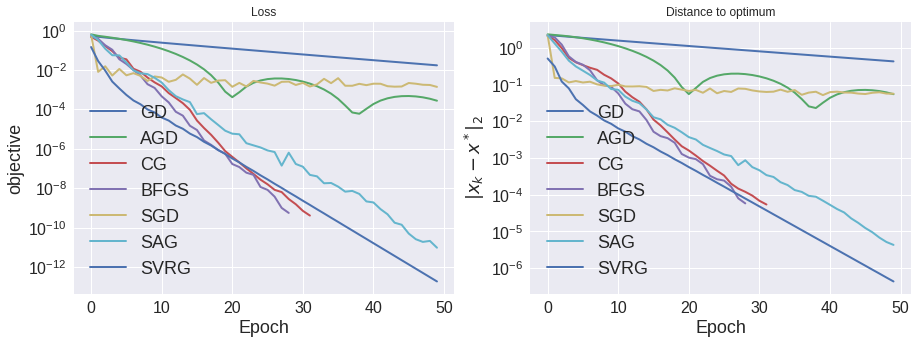

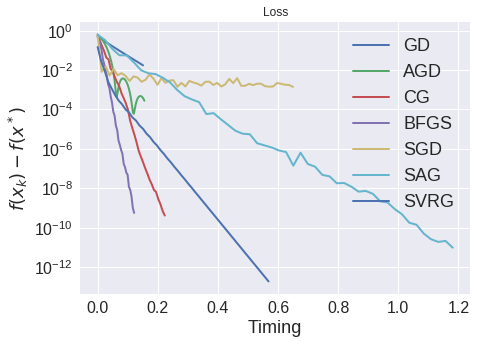

In [488]:
plot_monitor(simu_logreg,corr_=0.7,lbda_=1./n)

**Comment:**

We note that stochastic algorithms are slower than deterministic algorithms. this is predictable because, for each iteration, the SVRG and SAG methods calculate the  $\nabla$g and the $\nabla_i$ g at least once, which requires a lot of time.


### Low penalisation $ \lambda = \frac{1}{\sqrt{n}}$

Optimization terminated successfully.
         Current function value: 0.528789
         Iterations: 32
         Function evaluations: 53
         Gradient evaluations: 53


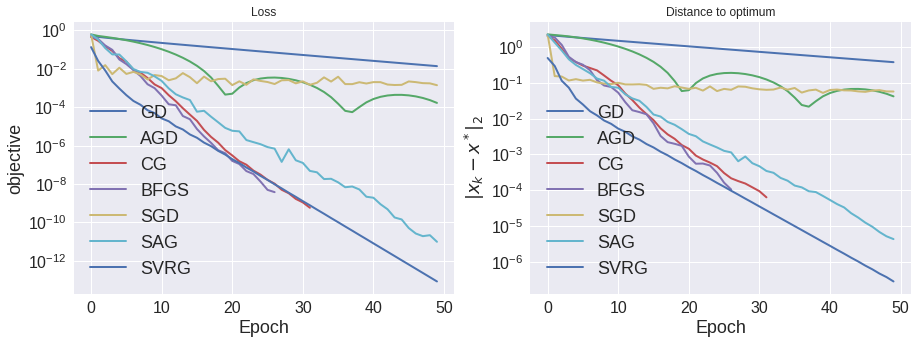

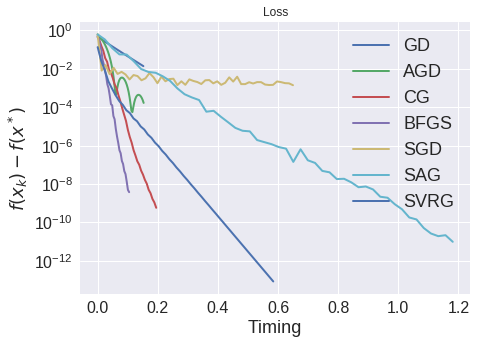

In [489]:
plot_monitor(simu_linreg,corr_=0.7,lbda_=1./n**(0.5))

**Comment:**

We can see that the variation of the term of the penalization does not have a significant effect on the convergence and the performance of the algorithm .

## Case 2: Logistic regression

In [0]:
loss = loss_logreg
grad = grad_logreg
grad_i = grad_i_logreg
lipschitz_constant = lipschitz_logreg
x_init = np.zeros(d)


### High penalisation $ \lambda = \frac{1}{n}$

Optimization terminated successfully.
         Current function value: 0.424123
         Iterations: 41
         Function evaluations: 84
         Gradient evaluations: 84


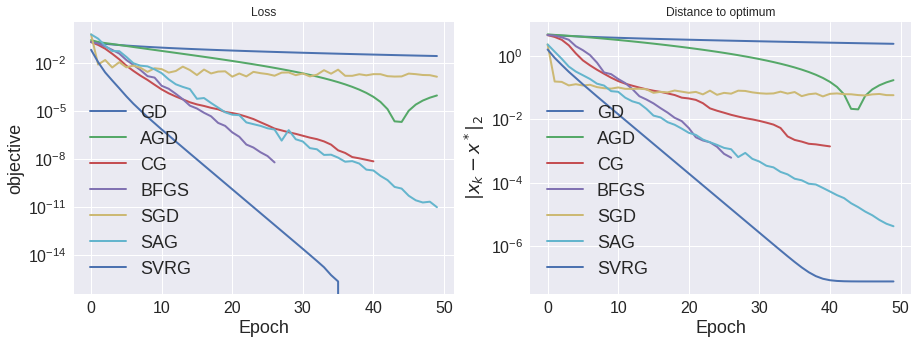

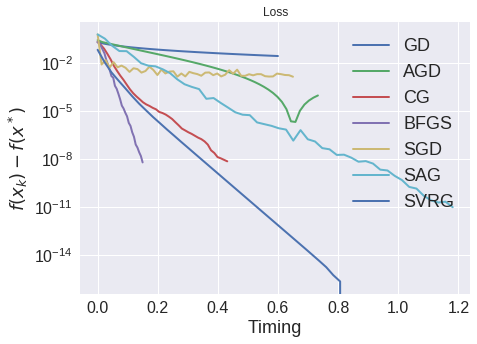

In [491]:
plot_monitor(simu_logreg,corr_=0.7,lbda_=1./n)

### Low penalisation $ \lambda = \frac{1}{\sqrt{n}}$

Optimization terminated successfully.
         Current function value: 0.477697
         Iterations: 25
         Function evaluations: 48
         Gradient evaluations: 48


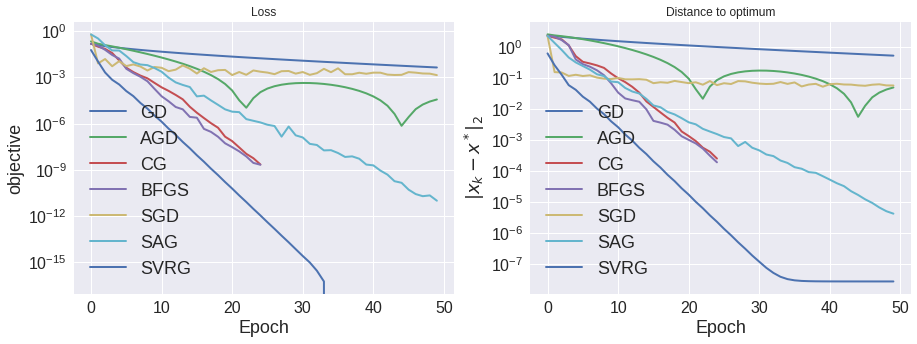

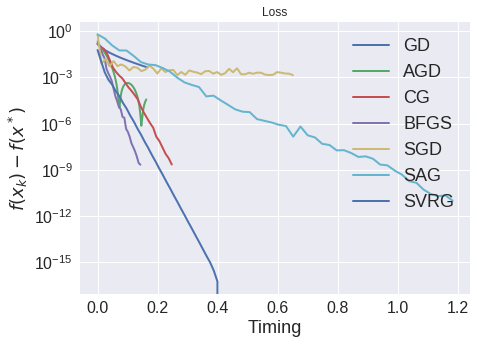

In [492]:
plot_monitor(simu_logreg,corr_=0.7,lbda_=1./n**(0.5))

**Comment:**

When we increase the term of penalization, we notice that most of the algorithms become really faster in terms of convergence. we can notably see this by visualizing this algorithm: the SVRG and SAG in the stochastic method and CG,AGD,CG for batch algoritm. For instance for the SVRG methods, when we change the term of penalisation $\lambda$ from $\lambda = \frac{1}{n} $  to $\lambda = \frac{1}{\sqrt{n}} $, the time needed to compute 50 iterations is divided by 2 (time =0.4 for the low penalization and time=0.8 for high penalization)

# The effect of correlation

## Case 1: Linear regression

In [0]:
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
x_init = np.zeros(d)

### Correlation = 0.4

Optimization terminated successfully.
         Current function value: 0.526853
         Iterations: 17
         Function evaluations: 26
         Gradient evaluations: 26


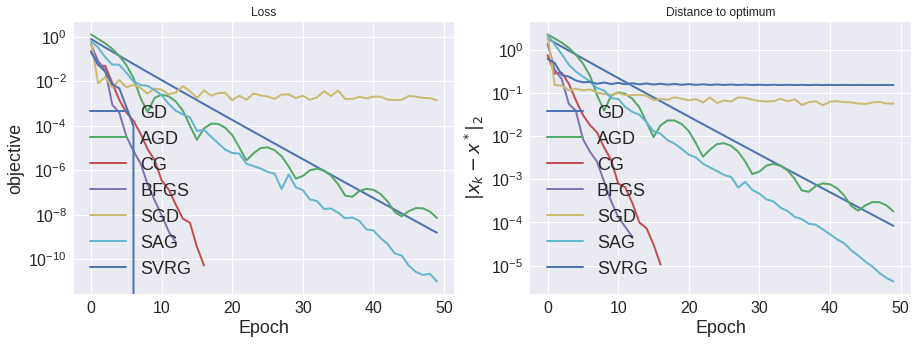

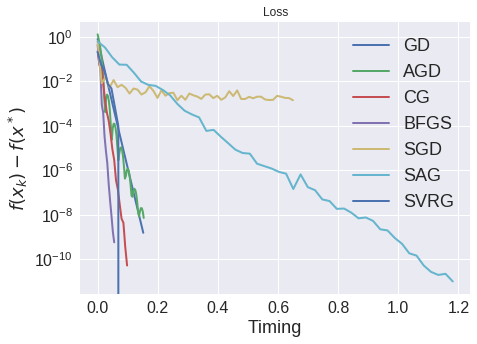

In [494]:
plot_monitor(simu_linreg,corr_=0.4,lbda_=1./n**(0.5),var_corr=True)

### Correlation = 0.8

         Current function value: 0.518000
         Iterations: 50
         Function evaluations: 82
         Gradient evaluations: 82


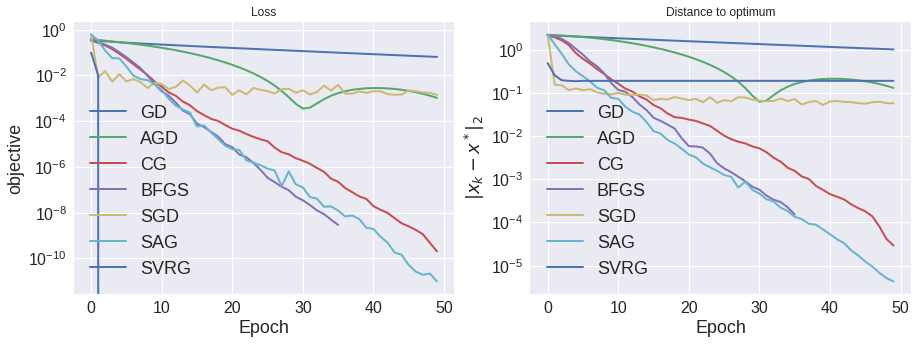

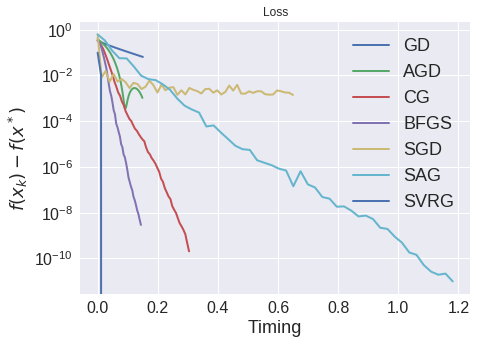

In [495]:
plot_monitor(simu_linreg,corr_=0.8,lbda_=1./n**(0.5),var_corr=True)

### Correlation =  1

Optimization terminated successfully.
         Current function value: 0.504056
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3


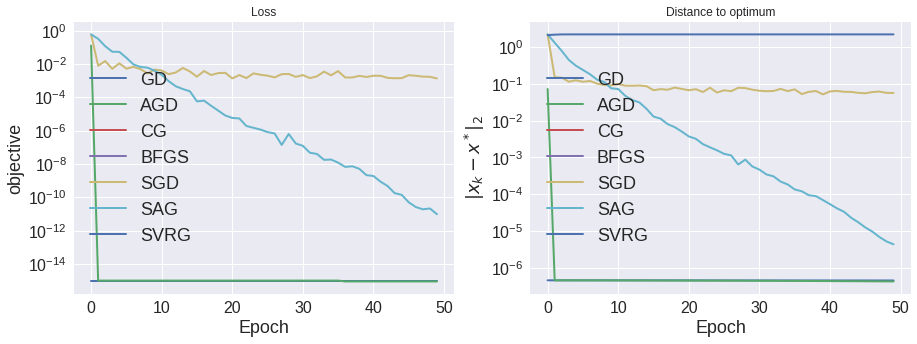

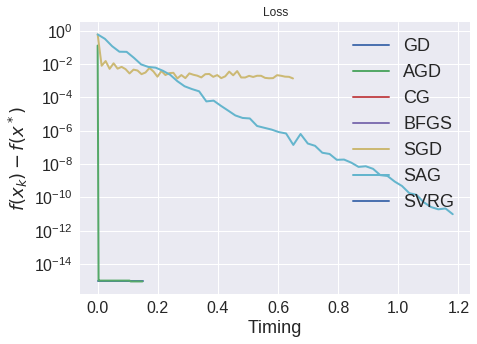

In [496]:
plot_monitor(simu_linreg,corr_=1,lbda_=1./n**(0.5),var_corr=True)

**Comment:**

We can see that the batch algorithms give a more efficient result than the stochastic algorithms. When we increase the correlation, the stochastic algorithms converge faster. It means that the stochastic methods are more stable when we increase the correlation . 

## Case 2: Logistic regression

In [0]:
loss = loss_logreg
grad = grad_logreg
grad_i = grad_i_logreg
lipschitz_constant = lipschitz_logreg
x_init = np.zeros(d)


### Correlation = 0

Optimization terminated successfully.
         Current function value: 0.333322
         Iterations: 10
         Function evaluations: 26
         Gradient evaluations: 26


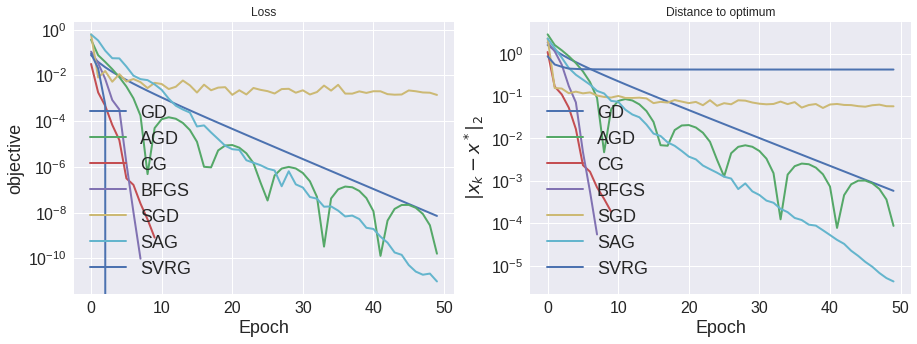

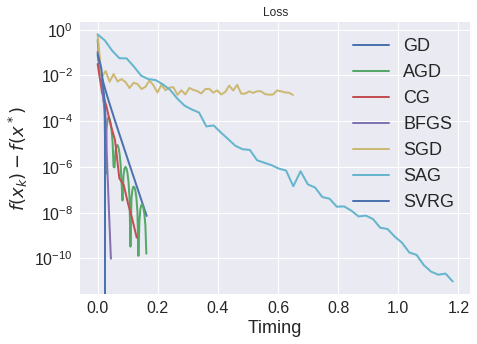

In [498]:
plot_monitor(simu_logreg,corr_=0,lbda_=1./n**(0.5),var_corr=True)

### Correlation = 0.4

Optimization terminated successfully.
         Current function value: 0.428777
         Iterations: 13
         Function evaluations: 29
         Gradient evaluations: 29


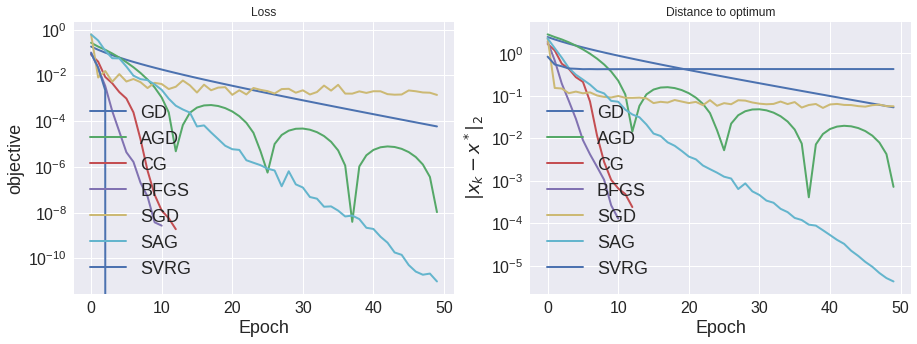

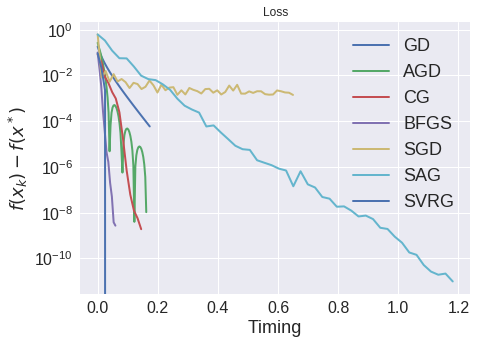

In [499]:
plot_monitor(simu_logreg,corr_=0.4,lbda_=1./n**(0.5),var_corr=True)

### Correlation = 0.8

Optimization terminated successfully.
         Current function value: 0.554637
         Iterations: 35
         Function evaluations: 66
         Gradient evaluations: 66


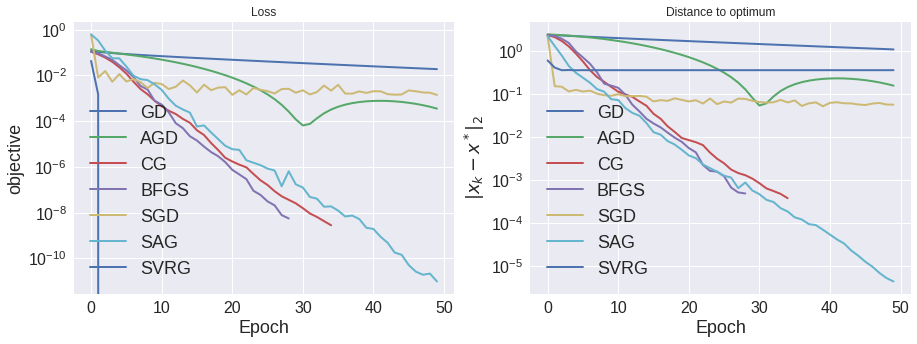

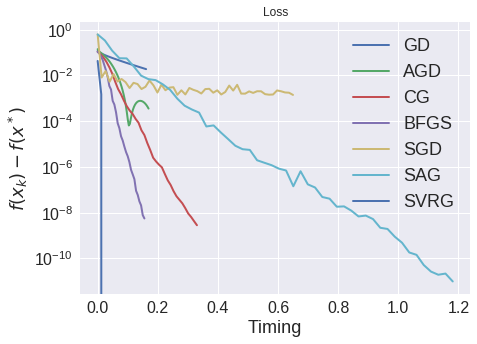

In [500]:
plot_monitor(simu_logreg,corr_=0.8,lbda_=1./n**(0.5),var_corr=True)

         Current function value: 0.600009
         Iterations: 50
         Function evaluations: 69
         Gradient evaluations: 69


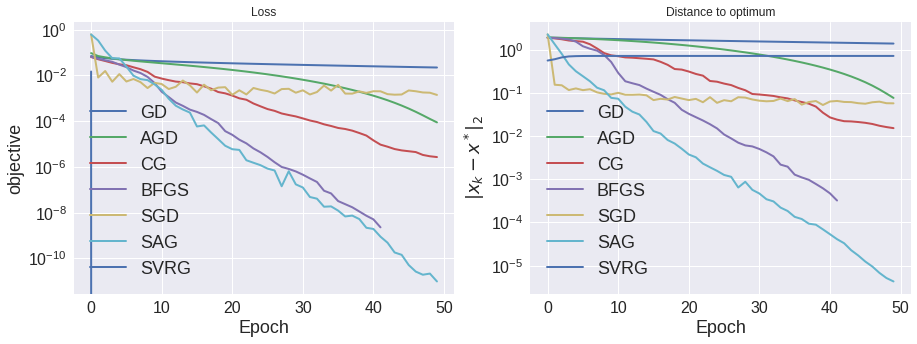

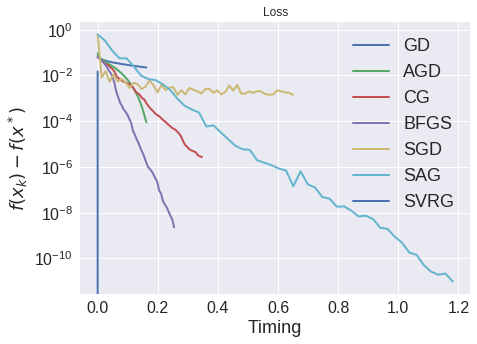

In [503]:
plot_monitor(simu_logreg,corr_=0.9,lbda_=1./n**(0.5),var_corr=True)

**Comment :**


 
For the logistic regression :


* In  case of low correlation (exemple for corr = 0 and corr=0.4), both SVRG, BFGS and CG methods works very well in term of speed of convergence and in term to the distance to the minimum.

 
* When we increase the correlation, all the deterministic algorithm become less performant and slow .However,  the performance of stochastic algorithm remains almost the same and is less sentitive to the variation of the correlation.


So, in case of higher correlation it would be better to use stochastic methods rather than batch methods because in one hand, batch methods suffers a lot from bad conditinning and in the other hand, stochastic methods will lead to a faster convergence and a lower distance to the minimum



## Summary of LAB2:

* The level of the ridge penalization doesn't have a huge effect on the performance of the deterministic and stochastic methods
* The stochastic algorithm are insentitive to the variation of the level of correlation
* The deterministic algoritm are sensitive to the level of correlation 
* In case of hight correlation (bad conditionning problem),the stochastic methods (SAG and SVRG) are preffered to the deterministic algorithm
* In case of low correlation, the scipy.optimize's BFGS and scipy.optimize's CG performs very well and gives us good results 